In [1]:
import pymongo as pmg
import pandas as pd
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from matplotlib.lines import TICKLEFT, TICKRIGHT, Line2D
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.dates as mdate
from datetime import time
from KRData.HKData import HKFuture
import talib as tb
import configparser
from corr import Analyse_CORR as CORR
from kline import Kline

OK
OK


In [2]:
conf_parser = configparser.ConfigParser()
conf_parser.read( 'conf.ini')
mg_host = conf_parser.get('MGDB', 'host')
mg_user = conf_parser.get('MGDB', 'user')
mg_password = conf_parser.get('MGDB', 'password')
hf=HKFuture(pwd=mg_password,host=mg_host,user=mg_user)
begin='2011-01-01'
dt1=dt.datetime.now()
_fields = ['datetime', 'code', 'open', 'high', 'low', 'close', 'vol','trade_date']
df=hf.get_bars('HSI1201',_fields)
df.head()

,datetime,code,open,high,low,close,trade_date
datetime,,,,,,,
2011-11-30 09:15:00,2011-11-30 09:15:00,HSI1201,18157.0,18157.0,18113.0,18113.0,2011-11-30
2011-11-30 09:17:00,2011-11-30 09:17:00,HSI1201,18131.0,18131.0,18130.0,18130.0,2011-11-30
2011-11-30 09:19:00,2011-11-30 09:19:00,HSI1201,18140.0,18140.0,18140.0,18140.0,2011-11-30
2011-11-30 09:21:00,2011-11-30 09:21:00,HSI1201,18127.0,18127.0,18115.0,18115.0,2011-11-30
2011-11-30 09:28:00,2011-11-30 09:28:00,HSI1201,18107.0,18107.0,18107.0,18107.0,2011-11-30


In [26]:
class backtesting():
    
#初始化-----------------------------------------------------------------------
    def __init__(self,hf:HKFuture,index='HSI'):
        self.hf=hf
        self._DateList=hf.get_main_contract_trade_dates(index)
        self.trade_para()
        self.Test_Trade=True
        self.cls()
    
#清理-----------------------------------------------------------------------------
    def cls(self):
        self._para={}
        self._res={}
        self._res['macd']=[]
        self._res['ma60']=[]
        self._res['trade']=[]
        
#当前指数全部品种进行测试---------------------------------------------------------------------
    def prod_all(self):
        self.cls()
        for k in self._DateList.keys():
            # print(k)
            self.prod_test(k)
            
#按单月合约进行测试-----------------------------------------------------------------------------
    def prod_test(self,prod):
        self.prod_init(prod)
        self._para['prod']=prod
        dt1=dt.time(9,15)
        dt2=dt.time(16,30)
        date_list=self._DateList[prod]
        self.dl=date_list
        for dd in date_list:
            self._para['date']=dd
            date1=str(dd.date())
            df=self._para['df_prod'][self._para['df_prod']['trade_date']==date1]
            if len(df)<2:
                break
            day_only=df.datetime.apply(lambda x:x.time()>=dt1 and x.time()<=dt2 )
            self._para['df1']=df[day_only]
            if len(df[day_only])<2:
                break
            self.day_loop()
    
#单月品种测试前的初如化---------------------------------------------------------------------------
    def prod_init(self,prod):
        _fields = ['datetime', 'code', 'open', 'high', 'low', 'close', 'vol','trade_date']
        df1=self.hf.get_bars(prod,_fields)
        df1['macd'],df1['diff'],df1['dea']=tb.MACD(df1.close.values,fastperiod=6,slowperiod=12,signalperiod=9)
        df1['ma30']=tb.EMA(df1.close.values,timeperiod=30)
        df1['ma60']=tb.EMA(df1.close.values,timeperiod=60)
        df1['bias']=(df1['close']-df1['ma60'])/df1['ma60']*100
        df1['chg']=df1['close']-df1['open']
        df1['std60']=tb.STDDEV(df1['chg'].values,timeperiod=60)
        df1['std1']=df1['chg']/df1['std60']
        self._para['df_prod']=df1

#交易日循环部分-----------------------------------------------------------------------------------
    def day_loop(self):
        self.day_init()
        df=self._para['df1']
        self._para['day_no']=0
        if self.Test_Trade:
            self.trade_init()
            for i,row in df.iterrows():
                self._para['row']=row
                self.loop_calc()
                self.trade_main()
                self._para['day_no']+=1
            self.trade_end()
        else:
            for i,row in df.iterrows():
                self._para['row']=row
                self.loop_calc()
                self._para['day_no']+=1
        
#交易日开始前准备----------------------------------------------------------------------------------
    def day_init(self):
        row1=self._para['df1'].iloc[0]
        self._para['macd']={}
        self._para['macd_no_red']=0
        self._para['macd_no_green']=0
        self._para['macd']['cnt']=1
        self._para['macd']['begin']=row1['close']
        self._para['macd']['state']='red' if row1['macd']>=0 else 'green'
        self._para['ma60']={}
        self._para['ma60_no_over']=0
        self._para['ma60_no_under']=0
        self._para['ma60']['cnt']=1
        self._para['ma60']['begin']=row1['close']
        self._para['ma60']['state']='over' if row1['close']>=row1['ma60'] else 'under'
      
      
#计算主体部分----------------------------------------------------------------------------------
    def loop_calc(self):
        self.calc_ma60()
        self.calc_macd()
        
#计算MA60------------------------------------------------------------------------------------------
    def calc_ma60(self):
        ma60=self._para['ma60']
        row=self._para['row']
        state=0
        if row['close']>=row['ma60'] and ma60['state'] =='under':
            state=1
            self._para['ma60_no_under']+=1
        elif row['close']<row['ma60'] and ma60['state']=='over':
            self._para['ma60_no_over']+=1
            state=2
        else:
            state=0
            ma60['cnt']+=1
        
        if state>0:
            ma60['prod']=self._para['prod']
            ma60['date']=self._para['date']
            ma60['end']=row['close']
            ma60['diff']=ma60['end']-ma60['begin'] if state==2 else ma60['begin']-ma60['end']
            ma60['no']=self._para['ma60_no_over'] if state==2 else self._para['ma60_no_under']
            self._res['ma60'].append(ma60)
#             print(ma60)
            ma60={}
            ma60['state']='over' if state==1 else 'under'
            ma60['begin']=row['close']
            ma60['cnt']=1
            self._para['macd_no_red']=0
            self._para['macd_no_green']=0
        self._para['ma60']=ma60
        
#计算MACD---------------------------------------------------------------------
    def calc_macd(self):
        macd=self._para['macd']
        row=self._para['row']
        state=0
        if row['macd']>0 and macd['state']=='green':
            state=1
            self._para['macd_no_red']+=1
        elif row['macd']<0 and macd['state']=='red':
            state=2
            self._para['macd_no_green']+=1
        else:
            macd['cnt']+=1

        if state>0:
            macd['prod']=self._para['prod']
            macd['date']=self._para['date']
            macd['end']=row['close']
            macd['diff']=macd['end']-macd['begin'] if state==2 else macd['begin']-macd['end']
            macd['no']=self._para['macd_no_red'] if state==2 else self._para['macd_no_green']
            self._res['macd'].append(macd)
            macd={}
            macd['cnt']=1
            macd['state']='red' if state==1 else 'green'
            macd['begin']=row['close']
            
        self._para['macd']=macd
    
#测试参数-----------------------------------------------------------------------
    def trade_para(self):
        self._StopList=['Close','MoveStop','FixStop','MoveStop_HL','FixStop_HL']
        self.StopType=self._StopList[0]
        self.Ma60_Begin=40
        self.StopRatio=0.5
        self.Rec_Begin=7
        self.Rec_Len=60
        self.WinRatio=2
        
#测试交易主体----------------------------------------------------------------
    def trade_main(self):
        if self._para['trade_p']['trade_state']==1:
            self.trade_stop()
        elif self._para['trade_p']['trade_state']==0:
            self.trade_open()
    
#每天交易的初始化-------------------------------------------------------------
    def trade_init(self):
        df1=self._para['df1']
        trade={}
        trade_p={}
        self._para['trade']={}
        self._para['trade_p']={}
        trade_p['rec_begin']=self.Rec_Begin
        trade_p['rec_len']=self.Rec_Len
        trade_p['rec_end']=trade_p['rec_begin']+trade_p['rec_len']-1
        preDF=df1[trade_p['rec_begin']:trade_p['rec_end']]
        IndexList=preDF.index.tolist()
        T_idx=preDF['close'].idxmax()
        B_idx=preDF['close'].idxmin()
        trade['top_idx']=IndexList.index(T_idx)
        trade['bottom_idx']=IndexList.index(B_idx)
        trade['rec_top']=preDF['close'].max()
        trade['rec_bottom']=preDF['close'].min()
        trade['rec_diff']=trade['rec_top']-trade['rec_bottom']
        trade_p['stop_diff']=trade['rec_diff']*self.StopRatio
        trade_p['stop_diff']=40 if trade_p['stop_diff']<40 else trade_p['stop_diff']
        trade_p['stop_diff']=220 if trade_p['stop_diff']>220 else trade_p['stop_diff']
        trade_p['trade_state']=0
        self._para['trade']=trade
        self._para['trade_p']=trade_p
        
#交易开仓条件-------------------------------------------------------------------------------
    def trade_open(self):
        if self._para['day_no']<=self._para['trade_p']['rec_end']:
            return
        
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        row=self._para['row']
        state=0
        if row['close']>trade['rec_top']:
            trade['state']='buy'
            trade['open']=row['close']
            trade['stop_price']=row['open']-trade_p['stop_diff']
            state=1
        elif row['close']<trade['rec_bottom']:
            trade['state']='sell'
            trade['open']=row['close']
            trade['stop_price']=row['open']+trade_p['stop_diff']
            state=2
        
        if state>0:
            trade_p['trade_state']=1
            trade['date']=self._para['date']
            if self._para['ma60']['state']=='over':
                trade['ma60_cnt']=self._para['ma60']['cnt']
            else:
                trade['ma60_cnt']=-self._para['ma60']['cnt']
#             trade['open']=row['close']
            trade['ma60_max']=trade['ma60_cnt']
            trade['bias']=row['bias']
            trade['bias_max']=row['bias']
            trade['open_idx']=self._para['day_no']-trade_p['rec_end']
        
        self._para['trade']=trade
        self._para['trade_p']=trade_p
    
#止损平仓--------------------------------------------------------------------------------------------
    def trade_stop(self):
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        row=self._para['row']
        
        trade['diff']=row['high']-trade['open'] if trade['state']=='buy' \
                                            else trade['open']-row['low']
        if  trade['diff']>=trade_p['stop_diff']*self.WinRatio:
            trade['close']=row['close']
            trade['close_type']='win'
            trade['close_idx']=self._para['day_no']-trade_p['rec_end']
            trade_p['trade_state']=2
            self._para['trade_p']=trade_p
            self._para['trade']=trade
            return
        
        if self.StopType=='MoveStop':
            if (row['close']-trade_p['stop_diff'])>trade['stop_price'] and trade['state']=='buy':
                trade['stop_price']=row['close']-trade_p['stop_diff']
                trade['ma60_max']=self._para['ma60']['cnt']
                trade['bias_max']=row['bias']
            elif (row['close']+trade_p['stop_diff'])<trade['stop_price'] and trade['state']=='sell':
                trade['stop_price']=row['close']+trade_p['stop_diff']
                trade['ma60_max']=-self._para['ma60']['cnt']
                trade['bias_max']=row['bias']
                
        cont1=all([row['close']<trade['stop_price'],trade['state']=='buy'])
        cont2=all([row['close']>trade['stop_price'],trade['state']=='sell'])
        if any([cont1,cont2]):
            trade['close']=row['close']
            trade['close_type']='stop'
            trade['close_idx']=self._para['day_no']-trade_p['rec_end']
            trade_p['trade_state']=2
                
        self._para['trade_p']=trade_p
        self._para['trade']=trade

#ma60平仓-------------------------------------------------------------------------------------------------
    def stop_ma60(self):
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        
        cont3=all([trade['ma60_max']>self.Ma60_Begin,trade['state']=='buy',row['close']<row['ma60']])
        cont4=all([trade['ma60_max']<-self.Ma60_Begin,trade['state']=='sell',row['close']>row['ma60']])
        if cont3 or cont4:
            trade['close']=row['close']
            trade['close_type']='ma60'
            trade['close_idx']=self._para['day_no']-trade_p['rec_end']
            trade_p['trade_state']=2
        self._para['trade_p']=trade_p
        self._para['trade']=trade

        
#每日交易结束----------------------------------------------------------------------------------
    def trade_end(self):
        if self._para['trade_p']['trade_state']==0:
            return
        trade=self._para['trade']
        row=self._para['row']
        if self._para['trade_p']['trade_state']==1:
            trade['close']=row['open']
            trade['close_type']='end'
            trade['close_idx']=self._para['day_no']-self._para['trade_p']['rec_end']-1
            
        trade['diff']=trade['close']-trade['open'] if trade['state']=='buy' \
                                            else trade['open']-trade['close']
        trade['prod']=self._para['prod']
        self._res['trade'].append(trade)
print("OK")

OK


In [8]:
def GetROI(F1):
    Res={}
    Res['ALL_Profit'],Res['All_CNT'],Res['All_Mean']=F1['diff'].agg(['sum','count','mean'])
    Res['Win_Sum'],Res['Win_CNT'],Res['Win_Mean'],Res['Win_Max'],Res['Win_Min']= \
        F1[F1['diff']>0]['diff'].agg(['sum','count','mean','max','min'])
    Res['Lose_Sum'],Res['Lose_CNT'],Res['Lose_Mean'],Res['Lose_Max'],Res['Lose_Min']=\
        F1[F1['diff']<0]['diff'].agg(['sum','count','mean','max','min'])
    Res['Win/Lose']=Res['Win_Mean']/-Res['Lose_Mean']
    Res['Win%']=Res['Win_CNT']*100/Res['All_CNT']
    Res['ROI']=Res['Win/Lose']*Res['Win%']-50.0
    return Res

In [11]:
class Open_BT(backtesting):
    def trade_main(self):
        if self._para['trade_p']['trade_state']==0:
            self.trade_open()
        if self._para['trade_p']['trade_state']==1:
            self.trade_stop()
    def trade_init(self):
        self._para['trade']={}
        self._para['trade_p']={}
        self._para['trade_p']['trade_state']=0
    def trade_open(self):
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        row=self._para['row']
        trade['open']=row['open']
        trade['state']='buy' if row['ma60']>row['open'] else 'sell'
        trade_p['trade_state']=1
        self._para['trade']=trade
        self._para['trade_p']=trade_p
        pass
    
    def trade_stop(self):
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        ma60=self._para['ma60']
        row=self._para['row']
        cont1=trade['state']=='buy'and ma60['state']=='under'
        cont2=trade['state']=='sell'and ma60['state']=='over'
        if any([cont1,cont2]):
            trade['close']=row['close']
            trade['close_type']='stop'
            trade['close_idx']=self._para['day_no']
            trade_p['trade_state']=2
        
            

In [27]:
#测试计算
time1=dt.datetime.now()
print(time1)
test=backtesting(hf)
test.StopType='MoveStop'
test.Test_Trade=False
test.prod_all()
# test.prod_test('HSI1109')
time2=dt.datetime.now()
print(time2-time1)
pd.DataFrame(test._res['macd'])

2019-05-29 15:08:44.385967
0:02:14.433689


,begin,cnt,date,diff,end,no,prod,state
0,23143.0,30,2011-01-03,20.0,23123.0,0,HSI1101,green
1,23123.0,18,2011-01-03,-4.0,23119.0,1,HSI1101,red
2,23119.0,5,2011-01-03,-12.0,23131.0,1,HSI1101,green
3,23131.0,43,2011-01-03,251.0,23382.0,0,HSI1101,red
4,23382.0,4,2011-01-03,-34.0,23416.0,1,HSI1101,green
5,23416.0,12,2011-01-03,-28.0,23388.0,1,HSI1101,red
6,23388.0,9,2011-01-03,-14.0,23402.0,2,HSI1101,green
7,23402.0,17,2011-01-03,0.0,23402.0,2,HSI1101,red
8,23402.0,28,2011-01-03,-7.0,23409.0,0,HSI1101,green
9,23409.0,5,2011-01-03,-40.0,23369.0,0,HSI1101,red


In [33]:
Calc=['sum','count','mean','std','max','min']
macd=pd.DataFrame(test._res['macd'])
print("MACD 相关")
macd.groupby(['state','no'])['diff'].agg(Calc)
# GetROI(macd[(macd.state=='red') &(macd.no>2)])

MACD 相关


sum  count       mean        std    max    min
state no                                                    
green 0  -21404.0  13136  -1.629415  37.719945  649.0 -205.0
      1   25373.0   7486   3.389394  41.751483  694.0 -310.0
      2  -12931.0   3266  -3.959277  31.502039  501.0  -90.0
      3   -8509.0   1522  -5.590670  25.443780  357.0  -88.0
      4   -3111.0    711  -4.375527  24.256398  198.0  -63.0
      5    -965.0    335  -2.880597  27.831143  173.0  -78.0
      6    -731.0    155  -4.716129  26.279654  171.0  -92.0
      7    -623.0     74  -8.418919  11.023023   35.0  -35.0
      8      87.0     29   3.000000  34.486022  131.0  -40.0
      9    -115.0     10 -11.500000  15.269796   19.0  -35.0
      10    -34.0      5  -6.800000   5.118594   -1.0  -15.0
      11    -35.0      3 -11.666667   5.859465   -5.0  -16.0
      12     -2.0      2  -1.000000  14.142136    9.0  -11.0
      13      9.0      1   9.000000        NaN    9.0    9.0
red   0  -25866.0  13205  -1.958803  38.159386  882.0 -235.0
      1   19446.0   7439   2.614061  37.169656  457.0 -148.0
      2  -14327.0   3287  -4.358686  29.104823  312.0  -80.0
      3   -5198.0   1510  -3.442384  31.670630  357.0 -129.0
      4   -3268.0    721  -4.532594  24.585437  166.0  -67.0
      5   -2043.0    327  -6.247706  25.684192  170.0  -62.0
      6    -481.0    162  -2.969136  28.920414  209.0  -71.0
      7       0.0     71   0.000000  24.049354  130.0  -37.0
      8    -119.0     27  -4.407407  16.855173   70.0  -21.0
      9    -109.0      9 -12.111111   7.801353   -4.0  -26.0
      10    178.0      4  44.500000  66.073192  128.0   -9.0
      11    -54.0      3 -18.000000  10.000000   -8.0  -28.0
      12     -6.0      1  -6.000000        NaN   -6.0   -6.0

In [38]:
cont=(macd.state=='red') & (macd.no==2)
macd[cont].sort_values('diff')
# GetROI(macd[cont])

,begin,cnt,date,diff,end,no,prod,state
28753,24213.0,6,2015-07-09,-80.0,24133.0,2,HSI1507,red
27079,27091.0,8,2015-04-10,-78.0,27013.0,2,HSI1504,red
29676,21432.0,6,2015-08-26,-77.0,21355.0,2,HSI1508,red
27053,27454.0,1,2015-04-09,-74.0,27380.0,2,HSI1504,red
29632,21583.0,10,2015-08-24,-70.0,21513.0,2,HSI1508,red
29655,21780.0,8,2015-08-25,-70.0,21710.0,2,HSI1508,red
35203,20625.0,2,2016-07-08,-68.0,20557.0,2,HSI1607,red
4105,17433.0,5,2011-09-26,-67.0,17366.0,2,HSI1109,red
48782,27316.0,9,2018-08-16,-66.0,27250.0,2,HSI1808,red
45815,30297.0,9,2018-03-07,-63.0,30234.0,2,HSI1803,red


In [14]:
time1=dt.datetime.now()
print(time1)
bt1=Open_BT(hf)
# bt1.prod_test('HSI1903')
bt1.prod_all()
bt1._res['trade']
df1=pd.DataFrame(bt1._res['trade'])
time2=dt.datetime.now()
print(time2-time1)
GetROI(df1)

2019-05-29 00:36:19.182393
0:02:41.378539


{'ALL_Profit': -1564.0,
 'All_CNT': 2016.0,
 'Win': 27033.0,
 'Win_CNT': 968.0,
 'Lose': -28597.0,
 'Lose_CNT': 1025.0,
 'Win_Mean': 27.926652892561982,
 'Lose_Mean': -27.89951219512195,
 'All_Mean': -0.7757936507936508,
 'Win/Lose': 1.0009728018629938,
 'Win%': 48.56999498243854,
 'ROI': -1.3827560359569517}

In [35]:
Calc=['sum','count','mean','std','max','min']
ma=pd.DataFrame(bt1._res['ma60'])
ma[ma.state=='over'].groupby(['state','no'])['diff'].agg(Calc)
ma[ma.state=='under'].groupby(['state','no'])['diff'].agg(Calc)
GetROI(ma[(ma.state=='under') &(ma.no>9)])
GetROI(ma[(ma.state=='over') &(ma.no>6)])

{'ALL_Profit': -48808.0,
 'All_CNT': 16359.0,
 'All_Mean': -2.9835564521058746,
 'Win_Sum': 61588.0,
 'Win_CNT': 2162.0,
 'Win_Mean': 28.486586493987048,
 'Win_Max': 454.0,
 'Win_Min': 1.0,
 'Lose_Sum': -110396.0,
 'Lose_CNT': 13864.0,
 'Lose_Mean': -7.962781304096942,
 'Lose_Max': -1.0,
 'Lose_Min': -94.0,
 'Win/Lose': 3.577466893299,
 'Win%': 13.215966746133626,
 'ROI': -2.720316502766444}

In [37]:
time1=dt.datetime.now()
print(time1)
test=backtesting(hf)
test.StopType='MoveStop'
test.prod_all()
# test.prod_test('HSI1109')
time2=dt.datetime.now()
print(time2-time1)
d1=pd.DataFrame(test._res['trade'])
GetROI(d1)

2019-05-29 01:06:16.444278
0:03:02.519032


{'ALL_Profit': 13863.0,
 'All_CNT': 1866.0,
 'All_Mean': 7.429260450160772,
 'Win_Sum': 65462.0,
 'Win_CNT': 767.0,
 'Win_Mean': 85.34810951760105,
 'Win_Max': 459.0,
 'Win_Min': 1.0,
 'Lose_Sum': -51599.0,
 'Lose_CNT': 1083.0,
 'Lose_Mean': -47.64450600184672,
 'Lose_Max': -1.0,
 'Lose_Min': -272.0,
 'Win/Lose': 1.7913525961270942,
 'Win%': 41.10396570203644,
 'ROI': 23.631695671462012}

In [40]:
Calc=['sum','count','mean','std','max','min']
ma=pd.DataFrame(test._res['ma60'])
ma[ma.state=='over'].groupby(['state','no'])['diff'].agg(Calc)
ma[ma.state=='under'].groupby(['state','no'])['diff'].agg(Calc)
# GetROI(ma[(ma.state=='under') &(ma.no>9)])
# GetROI(ma[(ma.state=='over') &(ma.no>7)])
#反向操作研究一下

sum  count      mean        std     max    min
state no                                                   
under 1   4501.0   2014  2.234856  80.366015  1056.0 -305.0
      2   1120.0   2010  0.557214  45.061398   634.0  -71.0
      3  -2289.0   2006 -1.141077  41.205628   998.0 -170.0
      4  -2739.0   1992 -1.375000  33.301922   514.0 -127.0
      5  -4201.0   1959 -2.144461  27.024127   501.0  -81.0
      6  -1535.0   1915 -0.801567  32.255435   538.0  -70.0
      7  -2353.0   1866 -1.260986  26.657352   404.0  -66.0
      8  -3280.0   1796 -1.826281  25.847914   418.0  -81.0
      9  -4192.0   1700 -2.465882  22.661117   285.0  -69.0
      10 -6366.0   1596 -3.988722  17.274400   260.0  -48.0
      11 -3875.0   1486 -2.607672  19.982556   234.0  -60.0
      12 -4711.0   1354 -3.479321  17.042704   178.0  -59.0
      13 -3310.0   1197 -2.765246  30.122868   794.0  -62.0
      14 -3963.0   1052 -3.767110  15.761602   229.0  -36.0
      15 -2591.0    904 -2.866150  20.325066   249.0  -68.0
      16 -2715.0    761 -3.567674  19.093908   270.0  -49.0
      17 -2321.0    624 -3.719551  17.409796   205.0  -57.0
      18 -1881.0    508 -3.702756  11.821329    90.0  -35.0
      19 -1707.0    395 -4.321519  13.623487   140.0  -37.0
      20 -1449.0    303 -4.782178  10.640362    90.0  -34.0
      21 -1198.0    229 -5.231441   7.492901    39.0  -39.0
      22  -361.0    167 -2.161677  27.608126   308.0  -25.0
      23  -522.0    127 -4.110236   8.615442    57.0  -30.0
      24  -563.0     92 -6.119565   5.613646     9.0  -26.0
      25  -275.0     60 -4.583333   5.666708    28.0  -16.0
      26  -140.0     37 -3.783784   4.243525     4.0  -15.0
      27  -134.0     23 -5.826087   4.941956     3.0  -20.0
      28   -46.0     14 -3.285714   5.689783    14.0  -13.0
      29   -12.0      8 -1.500000   4.105745     3.0   -9.0
      30   -26.0      3 -8.666667   9.073772    -2.0  -19.0
      31     0.0      2  0.000000   1.414214     1.0   -1.0
      32    -1.0      2 -0.500000   9.192388     6.0   -7.0

In [153]:
time1=dt.datetime.now()
print(time1)
test=Open_BT(hf)
# test.prod_test('HSI1109')
test.StopType='Close'
test.prod_all()
time2=dt.datetime.now()
print(time2-time1)
d1=pd.DataFrame(test._res['trade'])
GetROI(d1)

2019-05-27 00:24:55.593770
HSI1101
HSI1102
HSI1103
HSI1104
HSI1105
HSI1106
HSI1107
HSI1108
HSI1109
HSI1110
HSI1111
HSI1112
HSI1201
HSI1202
HSI1203
HSI1204
HSI1205
HSI1206
HSI1207
HSI1208
HSI1209
HSI1210
HSI1211
HSI1212
HSI1301
HSI1302
HSI1303
HSI1304
HSI1305
HSI1306
HSI1307
HSI1308
HSI1309
HSI1310
HSI1311
HSI1312
HSI1401
HSI1402
HSI1403
HSI1404
HSI1405
HSI1406
HSI1407
HSI1408
HSI1409
HSI1410
HSI1411
HSI1412
HSI1501
HSI1502
HSI1503
HSI1504
HSI1505
HSI1506
HSI1507
HSI1508
HSI1509
HSI1510
HSI1511
HSI1512
HSI1601
HSI1602
HSI1603
HSI1604
HSI1605
HSI1606
HSI1607
HSI1608
HSI1609
HSI1610
HSI1611
HSI1612
HSI1701
HSI1702
HSI1703
HSI1704
HSI1705
HSI1706
HSI1707
HSI1708
HSI1709
HSI1710
HSI1711
HSI1712
HSI1801
HSI1802
HSI1803
HSI1804
HSI1805
HSI1806
HSI1807
HSI1808
HSI1809
HSI1810
HSI1811
HSI1812
HSI1901
HSI1902
HSI1903
HSI1904
HSI1905
0:02:20.059975


{'ALL_Profit': -104.0,
 'All_CNT': 2016.0,
 'Win': 32794.0,
 'Win_CNT': 960.0,
 'Lose': -32898.0,
 'Lose_CNT': 1029.0,
 'Win_Mean': 34.16041666666667,
 'Lose_Mean': -31.97084548104956,
 'All_Mean': -0.051587301587301584,
 'Win/Lose': 1.068486496139583,
 'Win%': 48.26546003016591,
 'ROI': 1.570992272197067}

In [118]:
vs={}
print('close/move_stop')
vs['d1']=GetROI(d1)
vs['d2']=GetROI(d2)
d2.bias*100//10
d2.groupby(['state',d2.bias*100//10])['diff'].agg(Calc)
# d2.groupby(['state',d2.bias_max*100//10])['diff'].agg(Calc)

close/move_stop


sum  count        mean         std    max    min
state bias                                                      
buy   -1.0    -43.0      1  -43.000000         NaN  -43.0  -43.0
       0.0   1227.0     51   24.058824   80.092300  316.0  -97.0
       1.0   1460.0    330    4.424242   64.603693  271.0 -143.0
       2.0   2929.0    281   10.423488   91.910605  450.0 -207.0
       3.0    453.0    144    3.145833   97.380802  377.0 -196.0
       4.0    635.0     53   11.981132  119.134941  451.0 -148.0
       5.0   1518.0     21   72.285714  176.076728  407.0 -157.0
       6.0   -539.0     12  -44.916667  107.015257  247.0 -134.0
       7.0    473.0      5   94.600000  313.315017  649.0  -91.0
       8.0   -174.0      1 -174.000000         NaN -174.0 -174.0
       10.0  -151.0      1 -151.000000         NaN -151.0 -151.0
       15.0  -486.0      2 -243.000000   41.012193 -214.0 -272.0
sell  -14.0   562.0      1  562.000000         NaN  562.0  562.0
      -12.0  -348.0      2 -174.000000  137.178716  -77.0 -271.0
      -11.0   200.0      1  200.000000         NaN  200.0  200.0
      -10.0   136.0      1  136.000000         NaN  136.0  136.0
      -9.0   -141.0      2  -70.500000   12.020815  -62.0  -79.0
      -8.0    134.0      4   33.500000  144.981608  231.0  -83.0
      -7.0   1097.0     14   78.357143  267.972044  705.0 -208.0
      -6.0    399.0     20   19.950000  100.632460  237.0 -113.0
      -5.0   1203.0     59   20.389831  112.557115  314.0 -202.0
      -4.0   -400.0    155   -2.580645   93.627257  413.0 -136.0
      -3.0   3349.0    292   11.469178   90.332846  442.0 -152.0
      -2.0   1427.0    367    3.888283   70.619979  462.0 -118.0
      -1.0    480.0     45   10.666667   70.708107  266.0  -66.0
       1.0     39.0      1   39.000000         NaN   39.0   39.0

In [30]:
# 
Calc=['sum','count','mean','std','max','min']
time1=dt.datetime.now()
print(time1)
TestAll={}
df={}
ratio=[1,1.5,2,2.5,3,3.5,4,4.5,5]
for i in ratio:
    print(i)
    test=backtesting(hf,index='HSI')
    test.StopType='MoveStop'
    test.StopRatio=0.8
    test.Rec_Begin=7
    test.Rec_Len=60
    test.WinRatio=i
    test.prod_all()
#     test.prod_test('HSI1903')
    df[i]=pd.DataFrame(test._res['trade'])
    TestAll[i]=GetROI(df[i])
time2=dt.datetime.now()
print(time2-time1)
pd.DataFrame(TestAll).T

2019-05-28 15:38:15.381649
1
1.5
2
2.5
3
3.5
4
4.5
5
0:24:36.755466


,ALL_Profit,All_CNT,All_Mean,Lose,Lose_CNT,Lose_Mean,ROI,Win,Win%,Win/Lose,Win_CNT,Win_Mean
1.0,13434.0,1866.0,7.199357,-66016.0,955.0,-69.126702,11.958965,79450.0,48.517520,1.277043,900.0,88.277778
1.5,15859.0,1866.0,8.498928,-66812.0,1025.0,-65.182439,18.519812,82671.0,44.624527,1.535474,826.0,100.085956
2.0,17038.0,1866.0,9.130761,-66836.0,1028.0,-65.015564,19.695317,83874.0,44.462453,1.567510,823.0,101.912515
2.5,18600.0,1866.0,9.967846,-66836.0,1028.0,-65.015564,21.031640,85436.0,44.432432,1.598644,822.0,103.936740
3.0,19086.0,1866.0,10.228296,-66836.0,1028.0,-65.015564,21.435701,85922.0,44.432432,1.607738,822.0,104.527981
3.5,19089.0,1866.0,10.229904,-66836.0,1028.0,-65.015564,21.438196,85925.0,44.432432,1.607794,822.0,104.531630
4.0,19286.0,1866.0,10.335477,-66836.0,1028.0,-65.015564,21.601982,86122.0,44.432432,1.611480,822.0,104.771290
4.5,18827.0,1866.0,10.089496,-66836.0,1028.0,-65.015564,21.220368,85663.0,44.432432,1.602892,822.0,104.212895
5.0,18946.0,1866.0,10.153269,-66836.0,1028.0,-65.015564,21.319305,85782.0,44.432432,1.605118,822.0,104.357664


In [28]:
f1=df[3.5] 
f1[f1.close_type=='win']['diff'].agg(Calc)

sum      16186.000000
count       49.000000
mean       330.326531
std        163.253176
max        793.000000
min        157.000000
Name: diff, dtype: float64

In [46]:
print("ma60 index")
pd.DataFrame(TestAll).T
# d2['diff'].agg(Calc)
# d2.groupby('prod')['diff'].agg(Calc).to_excel("pkl/prod_ma60b.xls")

ma60 index


,count,max,mean,min,std,sum
20,1866.0,705.0,5.523044,-271.0,76.398404,10306.0
30,1866.0,705.0,5.629153,-271.0,77.875977,10504.0
40,1866.0,705.0,6.321008,-271.0,79.242928,11795.0
50,1866.0,705.0,6.013398,-271.0,81.312045,11221.0
60,1866.0,705.0,6.189711,-271.0,83.084985,11550.0
70,1866.0,705.0,6.198285,-271.0,84.210882,11566.0
80,1866.0,705.0,6.761522,-271.0,86.354928,12617.0
90,1866.0,705.0,6.880493,-271.0,87.399647,12839.0
100,1866.0,705.0,7.698285,-271.0,89.468311,14365.0
110,1866.0,705.0,7.803323,-271.0,90.087151,14561.0


In [48]:
df.keys()

dict_keys([20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190])

In [6]:
Calc=['sum','count','mean','std','max','min']
# d2=pd.DataFrame(test._res['trade'])
d2.groupby('state')['diff'].agg(Calc)
d2['diff'].agg(Calc)

sum      15206.000000
count     1866.000000
mean         8.148982
std         91.974739
max        705.000000
min       -272.000000
Name: diff, dtype: float64

In [13]:
pd.DataFrame(test._res['ma60'])

,begin,cnt,date,diff,end,no,prod,state
0,23143.0,60,2011-01-03,-146.0,23289.0,1,HSI1101,under
1,23289.0,91,2011-01-03,92.0,23381.0,1,HSI1101,over
2,23381.0,1,2011-01-03,-7.0,23388.0,2,HSI1101,under
3,23388.0,5,2011-01-03,-10.0,23378.0,2,HSI1101,over
4,23378.0,8,2011-01-03,-7.0,23385.0,3,HSI1101,under
5,23385.0,4,2011-01-03,-8.0,23377.0,3,HSI1101,over
6,23377.0,12,2011-01-03,-6.0,23383.0,4,HSI1101,under
7,23383.0,6,2011-01-03,-12.0,23371.0,4,HSI1101,over
8,23371.0,3,2011-01-03,-14.0,23385.0,5,HSI1101,under
9,23385.0,35,2011-01-03,28.0,23413.0,5,HSI1101,over


In [254]:
time1=dt.datetime.now()
print(time1)
test=backtesting(hf,index='HHI')
# test.prod_test('HSI1109')
test.prod_all()
time2=dt.datetime.now()
print(time2-time1)
# test._res['ma60']

2019-05-19 02:04:29.553804
HHI1101


NameError: name 't_para' is not defined

In [105]:
time1=dt.datetime.now()
print(time1)
test=backtesting(hf)
test.StopType='MoveStop'
test.prod_test('HSI1903')
# test.prod_all()
time2=dt.datetime.now()
print(time2-time1)
pd.DataFrame(test._res['trade'])

2019-05-26 16:14:46.502542
0:00:25.625120


,bias,bias_max,bottom_idx,close,close_idx,close_type,date,diff,ma60_cnt,ma60_max,open,open_idx,prod,rec_bottom,rec_diff,rec_top,state,stop_price,top_idx
0,0.259843,0.231175,5,28782.0,54,stop,2019-02-28,-121.0,57,58,28903.0,24,HSI1903,28660.0,224.0,28884.0,buy,28785.0,52
1,0.162847,0.283367,14,28786.0,46,stop,2019-03-01,26.0,14,33,28760.0,22,HSI1903,28672.0,86.0,28758.0,buy,28790.0,23
2,0.129299,0.143907,9,28792.0,11,stop,2019-03-04,-41.0,15,17,28833.0,6,HSI1903,28734.0,92.0,28826.0,buy,28794.0,58
3,0.146647,0.400695,2,28880.0,46,stop,2019-03-05,68.0,8,34,28812.0,15,HSI1903,28686.0,115.0,28801.0,buy,28892.5,15
4,0.279404,0.279404,5,28964.0,32,stop,2019-03-06,-107.0,23,23,29071.0,18,HSI1903,28876.0,189.0,29065.0,buy,28969.5,29
5,-0.359485,-0.320984,18,28896.0,53,stop,2019-03-07,-74.0,-39,-40,28822.0,44,HSI1903,28878.0,115.0,28993.0,sell,28887.5,45
6,0.027101,0.240490,8,28441.0,27,stop,2019-03-08,15.0,1,12,28426.0,5,HSI1903,28312.0,111.0,28423.0,buy,28444.5,56
7,0.159731,0.178393,0,28388.0,114,stop,2019-03-11,39.0,25,98,28349.0,35,HSI1903,28227.0,116.0,28343.0,buy,28396.0,39
8,0.232627,0.102137,8,28895.0,142,stop,2019-03-12,38.0,71,6,28857.0,3,HSI1903,28755.0,101.0,28856.0,buy,28902.5,23
9,-0.314431,-0.319183,58,28820.0,25,stop,2019-03-13,-74.0,-34,-43,28746.0,3,HSI1903,28756.0,189.0,28945.0,sell,28812.5,6


In [38]:
Calc=['sum','count','mean','std','max','min']
f1=pd.DataFrame(test._res['trade'])
f1['diff'].agg(Calc)
f1.groupby(['state','close_type'])['diff'].agg(Calc)
f1.groupby(['state'])['diff'].agg(Calc)
f1.head()

,bottom_idx,close,close_idx,close_type,date,diff,ma60_cnt,open,open_idx,prod,rec_bottom,rec_diff,rec_top,state,stop_price,top_idx
0,5,28840.0,37,ma60,2019-02-28,-63.0,57,28903.0,24,HSI1903,28660.0,224.0,28884.0,buy,28785.0,52
1,14,28786.0,46,stop,2019-03-01,26.0,14,28760.0,22,HSI1903,28672.0,86.0,28758.0,buy,28790.0,23
2,9,28792.0,11,stop,2019-03-04,-41.0,15,28833.0,6,HSI1903,28734.0,92.0,28826.0,buy,28794.0,58
3,2,28880.0,46,stop,2019-03-05,68.0,8,28812.0,15,HSI1903,28686.0,115.0,28801.0,buy,28892.5,15
4,5,28964.0,32,stop,2019-03-06,-107.0,23,29071.0,18,HSI1903,28876.0,189.0,29065.0,buy,28969.5,29


In [222]:
f1=test._para['df_prod']
f2=f1[f1.trade_date==test._para['date']]
dt1=dt.time(9,15)
dt2=dt.time(16,30)
day_only=f2.datetime.apply(lambda x:x.time()>=dt1 and x.time()<=dt2 )
f2

,datetime,code,open,high,low,close,trade_date,macd,diff,dea,ma30,ma60,chg,std60,std1
datetime,,,,,,,,,,,,,,,
2016-08-01 17:15:00,2016-08-01 17:15:00,HSI1608,22114.0,22114.0,22072.0,22080.0,2016-08-02,1.188469,3.995586,-2.807117,22100.842455,22108.265781,-34.0,9.025566,-3.767077
2016-08-01 17:16:00,2016-08-01 17:16:00,HSI1608,22083.0,22086.0,22071.0,22073.0,2016-08-02,-3.136552,2.569158,-5.705710,22099.046167,22107.109526,-10.0,8.859772,-1.128697
2016-08-01 17:17:00,2016-08-01 17:17:00,HSI1608,22072.0,22073.0,22066.0,22066.0,2016-08-02,-6.535782,0.748170,-7.283952,22096.914157,22105.761672,-6.0,8.880065,-0.675671
2016-08-01 17:18:00,2016-08-01 17:18:00,HSI1608,22063.0,22064.0,22055.0,22060.0,2016-08-02,-9.094183,-1.220300,-7.873883,22094.532598,22104.261290,-3.0,7.936886,-0.377982
2016-08-01 17:19:00,2016-08-01 17:19:00,HSI1608,22061.0,22067.0,22058.0,22065.0,2016-08-02,-9.581385,-2.892517,-6.688867,22092.627269,22102.974034,4.0,7.772655,0.514625
2016-08-01 17:20:00,2016-08-01 17:20:00,HSI1608,22067.0,22067.0,22058.0,22058.0,2016-08-02,-10.377764,-4.389567,-5.988198,22090.393252,22101.499476,-9.0,7.671810,-1.173126
2016-08-01 17:21:00,2016-08-01 17:21:00,HSI1608,22057.0,22062.0,22052.0,22062.0,2016-08-02,-9.875455,-5.486744,-4.388710,22088.561429,22100.204411,5.0,7.671810,0.651737
2016-08-01 17:22:00,2016-08-01 17:22:00,HSI1608,22063.0,22063.0,22056.0,22061.0,2016-08-02,-9.269643,-6.243324,-3.026319,22086.783272,22098.919021,-2.0,7.669039,-0.260789
2016-08-01 17:23:00,2016-08-01 17:23:00,HSI1608,22060.0,22060.0,22056.0,22060.0,2016-08-02,-8.627905,-6.720240,-1.907664,22085.055319,22097.642987,0.0,7.669039,0.000000


In [5]:
hf.get_main_contract_trade_dates('HSI', '20110101','20190501')
HSI_Date=hf.get_main_contract_trade_dates('HSI')

In [203]:
HSI_Date['HSI1109']

[datetime.datetime(2011, 8, 31, 0, 0),
 datetime.datetime(2011, 9, 1, 0, 0),
 datetime.datetime(2011, 9, 2, 0, 0),
 datetime.datetime(2011, 9, 5, 0, 0),
 datetime.datetime(2011, 9, 6, 0, 0),
 datetime.datetime(2011, 9, 7, 0, 0),
 datetime.datetime(2011, 9, 8, 0, 0),
 datetime.datetime(2011, 9, 9, 0, 0),
 datetime.datetime(2011, 9, 12, 0, 0),
 datetime.datetime(2011, 9, 14, 0, 0),
 datetime.datetime(2011, 9, 15, 0, 0),
 datetime.datetime(2011, 9, 16, 0, 0),
 datetime.datetime(2011, 9, 19, 0, 0),
 datetime.datetime(2011, 9, 20, 0, 0),
 datetime.datetime(2011, 9, 21, 0, 0),
 datetime.datetime(2011, 9, 22, 0, 0),
 datetime.datetime(2011, 9, 23, 0, 0),
 datetime.datetime(2011, 9, 26, 0, 0),
 datetime.datetime(2011, 9, 27, 0, 0),
 datetime.datetime(2011, 9, 28, 0, 0),
 datetime.datetime(2011, 9, 29, 0, 0),
 datetime.datetime(2011, 9, 30, 0, 0)]

In [120]:
for i in dl['HSI1904']:
    print(i)

2019-03-29 00:00:00
2019-04-01 00:00:00
2019-04-02 00:00:00
2019-04-03 00:00:00
2019-04-04 00:00:00
2019-04-08 00:00:00
2019-04-09 00:00:00
2019-04-10 00:00:00
2019-04-11 00:00:00
2019-04-12 00:00:00
2019-04-15 00:00:00
2019-04-16 00:00:00
2019-04-17 00:00:00
2019-04-18 00:00:00
2019-04-23 00:00:00
2019-04-24 00:00:00
2019-04-25 00:00:00
2019-04-26 00:00:00
2019-04-29 00:00:00


In [99]:
dt1=hf.get_bars(ll[0],_fields)
dt1.trade_date.unique()[0]

numpy.datetime64('2011-01-03T00:00:00.000000000')

In [105]:
date1=HSI_Date['HSI1904'][1]
d1[str(date1.date())]
print(date1)
print(date1.date())
d1[str(date1.date())]
d1.resample('B').min()

2019-04-01 00:00:00
2019-04-01


,datetime,code,open,high,low,close,trade_date
datetime,,,,,,,
2019-02-28,2019-02-28 09:21:00,HSI1904,28600.0,28600.0,28600.0,28600.0,2019-02-28
2019-03-01,2019-03-01 09:33:00,HSI1904,28719.0,28719.0,28719.0,28719.0,2019-03-01
2019-03-04,2019-03-04 09:15:00,HSI1904,28791.0,28797.0,28774.0,28774.0,2019-03-04
2019-03-05,2019-03-05 09:19:00,HSI1904,28726.0,28726.0,28726.0,28726.0,2019-03-05
2019-03-06,2019-03-06 09:15:00,HSI1904,28909.0,28909.0,28909.0,28909.0,2019-03-06
2019-03-07,2019-03-07 09:15:00,HSI1904,28765.0,28765.0,28765.0,28765.0,2019-03-07
2019-03-08,2019-03-08 09:15:00,HSI1904,28215.0,28215.0,28215.0,28215.0,2019-03-08
2019-03-11,2019-03-11 09:15:00,HSI1904,28188.0,28188.0,28188.0,28188.0,2019-03-11
2019-03-12,2019-03-12 09:15:00,HSI1904,28760.0,28781.0,28760.0,28781.0,2019-03-12


In [128]:
tr=d2[(d2.bias>1.01)]
tr.head()

,bias,bias_max,bottom_idx,close,close_idx,close_type,date,diff,ma60_cnt,ma60_max,open,open_idx,prod,rec_bottom,rec_diff,rec_top,state,stop_price,top_idx
1058,1.524944,1.187554,7,21596.0,38,stop,2015-08-25,-214.0,72,83,21810.0,4,HSI1508,20927.0,866.0,21793.0,buy,21598.0,55
1059,1.061715,1.261839,15,21463.0,132,stop,2015-08-26,-151.0,46,50,21614.0,99,HSI1508,21080.0,387.0,21467.0,buy,21494.5,39
1102,1.560452,0.335820,0,23026.0,112,stop,2015-11-04,-272.0,69,137,23298.0,1,HSI1511,22690.0,515.0,23205.0,buy,23084.0,58


In [130]:
from kline import Kline
k=Kline()
t1=dt.time(9,15,0)
t2=dt.time(16,30,0)
# a2=aa[aa.datetime.apply(lambda x:t1<=x.time()<=t2)]
rec_end=66
for i,row in tr.iterrows():
    state=row.state
    begin=row.open_idx+rec_end
    end=row.close_idx+rec_end
    test1=backtesting(hf)
    test1.prod_init(row['prod'])
    aa=test1._para['df_prod']
    a2=aa[aa.datetime.apply(lambda x:t1<=x.time()<=t2)]
    file="img/bias_%s.jpg"%(row.date.date())
    k.DrawKline(a2[a2.trade_date==row.date],rec=(7,66),trade=(state,begin,end),save=file)

img/bias_2015-08-25.jpg
img/bias_2015-08-26.jpg
img/bias_2015-11-04.jpg


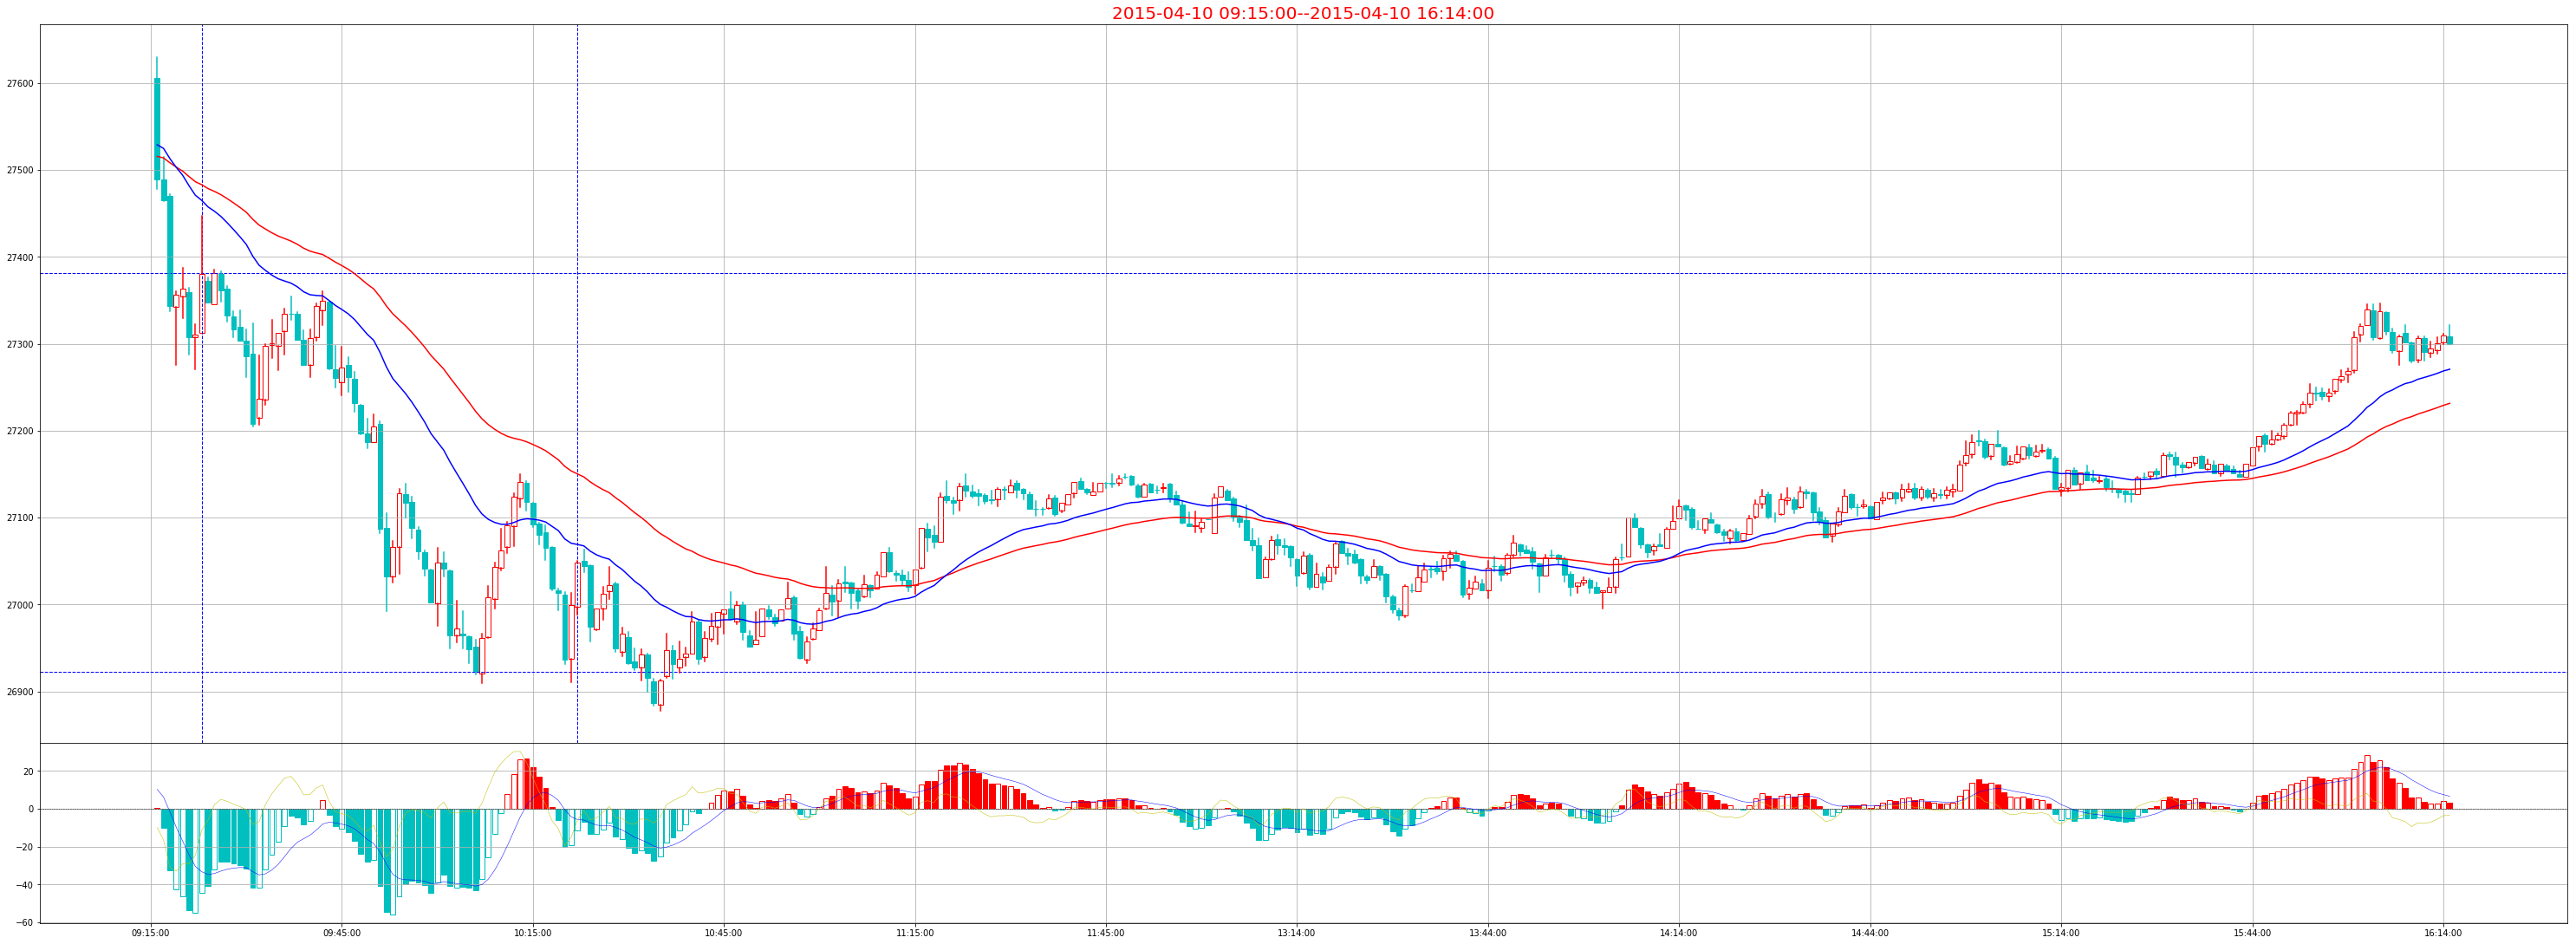

In [41]:
from kline import Kline
k=Kline()
t1=dt.time(9,15,0)
t2=dt.time(16,30,0)
# a2=aa[aa.datetime.apply(lambda x:t1<=x.time()<=t2)]
rec_end=66
test1=backtesting(hf)
prod='HSI1504'
test1.prod_init(prod)
aa=test1._para['df_prod']
a2=aa[aa.datetime.apply(lambda x:t1<=x.time()<=t2)]
date='2015-04-10'
k.DrawKline(a2[a2.trade_date==date],rec=(7,66))

In [25]:
row=tr.iloc[20]
state=row.state
begin=row.open_idx+rec_end
end=row.close_idx+rec_end
file="img/%s.jpg"%(row.date.date())
print(end)
a3=a2[a2.trade_date==row.date]
k.DrawKline(a2[a2.trade_date==row.date],rec=(7,66),trade=(state,begin,end))

340
img/2019-03-28.jpg
